In [22]:
# ============================================
# SAVE ALL RESULTS
# ============================================
print("SAVING RESULTS")
print("="*60)

# Save model comparison results
results_df.to_csv('../results/model_comparison.csv', index=False)
print("Saved: results/model_comparison.csv")

# Save CV results
cv_df.to_csv('../results/cross_validation_results.csv', index=False)
print("Saved: results/cross_validation_results.csv")

# Save tuning results
tuning_df.to_csv('../results/hyperparameter_tuning.csv', index=False)
print("Saved: results/hyperparameter_tuning.csv")

print(f"\n All ML results saved to /results folder!")

SAVING RESULTS
Saved: results/model_comparison.csv
Saved: results/cross_validation_results.csv
Saved: results/hyperparameter_tuning.csv

 All ML results saved to /results folder!


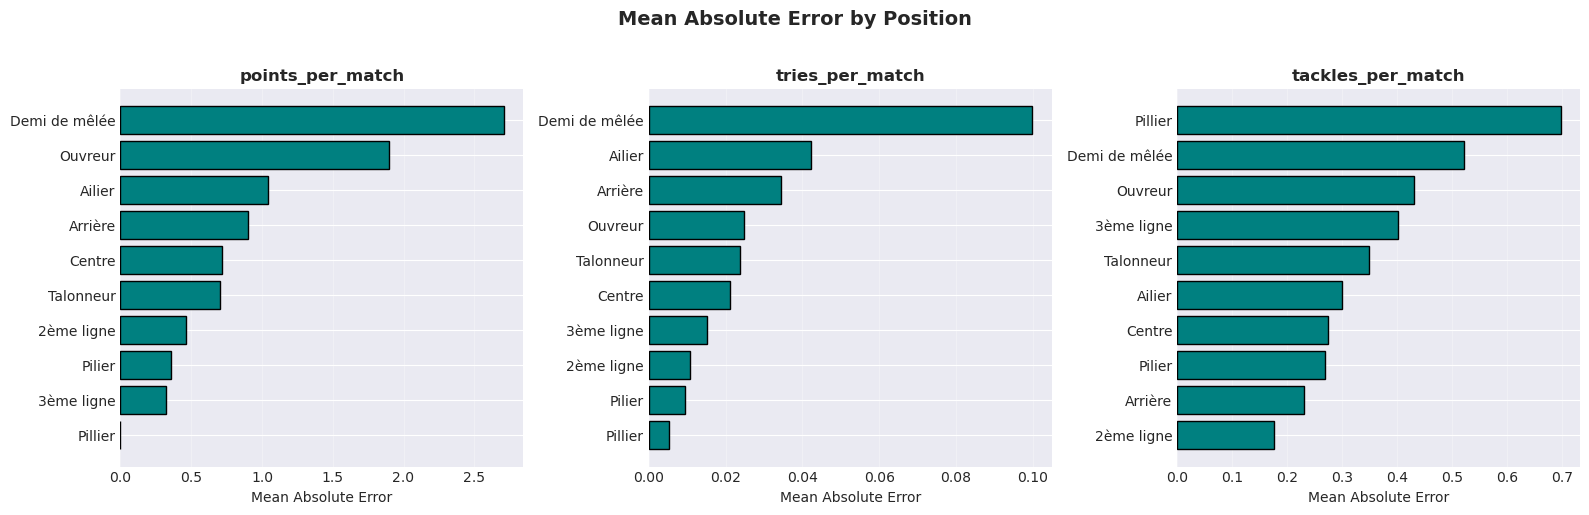

In [21]:
# Visualize errors by position for each target
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, target in enumerate(targets):
    model_name, model = best_models_final[target]
    
    if model is None:
        y_pred = y_train[target]
    else:
        if model_name == 'Linear Regression':
            model.fit(X_train_scaled, y_train[target])
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train[target])
            y_pred = model.predict(X_test)
    
    # Calculate errors by position
    error_df = pd.DataFrame({
        'Position': test_aligned['position'].values,
        'Abs_Error': np.abs(y_test[target] - y_pred)
    })
    
    pos_errors = error_df.groupby('Position')['Abs_Error'].mean().sort_values(ascending=True)
    
    axes[i].barh(pos_errors.index, pos_errors.values, color='teal', edgecolor='black')
    axes[i].set_xlabel('Mean Absolute Error')
    axes[i].set_title(f'{target}', fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)

plt.suptitle('Mean Absolute Error by Position', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# ============================================
# 4. ERROR ANALYSIS
# ============================================
print("ERROR ANALYSIS")
print("="*60)
print("Analyzing where and why our models make mistakes")
print("="*60)

# Use best models for each target
best_models_final = {
    'points_per_match': ('Naive Baseline', None),  # Baseline is best
    'tries_per_match': ('Gradient Boosting', GradientBoostingRegressor(
        learning_rate=0.1, max_depth=3, n_estimators=200, random_state=42)),
    'tackles_per_match': ('Linear Regression', LinearRegression())
}

error_analysis = []

for target in targets:
    model_name, model = best_models_final[target]
    
    if model is None:
        # Naive baseline
        y_pred = y_train[target]
    else:
        # Train and predict
        if model_name == 'Linear Regression':
            model.fit(X_train_scaled, y_train[target])
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train[target])
            y_pred = model.predict(X_test)
    
    # Calculate errors
    errors = y_test[target] - y_pred
    
    # Store for analysis
    error_df = pd.DataFrame({
        'Player': test_aligned['player_name'].values,
        'Position': test_aligned['position'].values,
        'Actual': y_test[target],
        'Predicted': y_pred,
        'Error': errors,
        'Abs_Error': np.abs(errors)
    })
    
    print(f"\n {target} ({model_name})")
    print("-" * 50)
    
    # Biggest errors
    print("\n    Top 5 OVER-predictions (predicted > actual):")
    over = error_df.nsmallest(5, 'Error')[['Player', 'Position', 'Actual', 'Predicted', 'Error']]
    print(over.to_string(index=False))
    
    print("\n    Top 5 UNDER-predictions (predicted < actual):")
    under = error_df.nlargest(5, 'Error')[['Player', 'Position', 'Actual', 'Predicted', 'Error']]
    print(under.to_string(index=False))
    
    # Error by position
    print("\n    Mean Absolute Error by Position:")
    pos_errors = error_df.groupby('Position')['Abs_Error'].mean().sort_values(ascending=False)
    print(pos_errors.head(5).to_string())

print(f"\n Error analysis complete!")

ERROR ANALYSIS
Analyzing where and why our models make mistakes

 points_per_match (Naive Baseline)
--------------------------------------------------

    Top 5 OVER-predictions (predicted > actual):
          Player      Position    Actual  Predicted     Error
  Melvyn Jaminet       Ouvreur 10.000000  15.000000 -5.000000
   Matthis Lebel        Ailier  0.217391   2.941176 -2.723785
Pierre Bourgarit     Talonneur  1.666667   3.750000 -2.083333
     Maxime Lucu Demi de mêlée  4.150000   6.210526 -2.060526
   Samuel Ezeala        Centre  0.909091   2.647059 -1.737968

    Top 5 UNDER-predictions (predicted < actual):
          Player      Position    Actual  Predicted    Error
Nolann Le Garrec Demi de mêlée 12.000000   5.894737 6.105263
Jérémy Fernandez Demi de mêlée  6.217391   2.000000 4.217391
        Léo Coly Demi de mêlée  5.210526   1.105263 4.105263
    Thomas Ramos       Arrière 15.642857  11.923077 3.719780
  Antoine Dupont Demi de mêlée  5.000000   2.142857 2.857143

    Mean 

In [19]:
# ============================================
# HYPERPARAMETER TUNING - points_per_match
# ============================================
print("HYPERPARAMETER TUNING - points_per_match")
print("="*60)

target = 'points_per_match'

# Random Forest
print("   Tuning Random Forest...")
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train[target])

print(f"   Best params: {grid_rf.best_params_}")
print(f"   Best CV R²: {grid_rf.best_score_:.3f}")

# Gradient Boosting
print("   Tuning Gradient Boosting...")
gb = GradientBoostingRegressor(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=3, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train[target])

print(f"   Best params: {grid_gb.best_params_}")
print(f"   Best CV R²: {grid_gb.best_score_:.3f}")

# Compare with baseline
print(f"\nComparison:")
print(f"   Baseline R²: 0.695")
print(f"   RF tuned CV R²: {grid_rf.best_score_:.3f}")
print(f"   GB tuned CV R²: {grid_gb.best_score_:.3f}")

if max(grid_rf.best_score_, grid_gb.best_score_) > 0.695:
    print("   Tuned model beats baseline!")
else:
    print("   Baseline still better - confirms our earlier finding")

HYPERPARAMETER TUNING - points_per_match
   Tuning Random Forest...
   Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
   Best CV R²: 0.134
   Tuning Gradient Boosting...
   Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
   Best CV R²: -0.024

Comparison:
   Baseline R²: 0.695
   RF tuned CV R²: 0.134
   GB tuned CV R²: -0.024
   Baseline still better - confirms our earlier finding


In [18]:
# ============================================
# 3. HYPERPARAMETER TUNING (GridSearchCV)
# ============================================
from sklearn.model_selection import GridSearchCV

print(" HYPERPARAMETER TUNING")
print("="*60)
print("Optimizing Random Forest and Gradient Boosting")
print("="*60)

# Parameters to tune
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

tuning_results = []

# Only tune for the 2 targets where ML models beat baseline
targets_to_tune = ['tries_per_match', 'tackles_per_match']

for target in targets_to_tune:
    print(f"\n {target}")
    print("-" * 40)
    
    # Random Forest
    print("   Tuning Random Forest...")
    rf = RandomForestRegressor(random_state=42)
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
    grid_rf.fit(X_train, y_train[target])
    
    print(f"   Best params: {grid_rf.best_params_}")
    print(f"   Best CV R²: {grid_rf.best_score_:.3f}")
    
    tuning_results.append({
        'Target': target,
        'Model': 'Random Forest (tuned)',
        'Best_Params': str(grid_rf.best_params_),
        'CV_R2': grid_rf.best_score_
    })
    
    # Gradient Boosting
    print("   Tuning Gradient Boosting...")
    gb = GradientBoostingRegressor(random_state=42)
    grid_gb = GridSearchCV(gb, param_grid_gb, cv=3, scoring='r2', n_jobs=-1)
    grid_gb.fit(X_train, y_train[target])
    
    print(f"   Best params: {grid_gb.best_params_}")
    print(f"   Best CV R²: {grid_gb.best_score_:.3f}")
    
    tuning_results.append({
        'Target': target,
        'Model': 'Gradient Boosting (tuned)',
        'Best_Params': str(grid_gb.best_params_),
        'CV_R2': grid_gb.best_score_
    })

tuning_df = pd.DataFrame(tuning_results)
print(f"\n Hyperparameter tuning complete!")

 HYPERPARAMETER TUNING
Optimizing Random Forest and Gradient Boosting

 tries_per_match
----------------------------------------
   Tuning Random Forest...
   Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
   Best CV R²: 0.789
   Tuning Gradient Boosting...
   Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
   Best CV R²: 0.835

 tackles_per_match
----------------------------------------
   Tuning Random Forest...
   Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
   Best CV R²: 0.708
   Tuning Gradient Boosting...
   Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
   Best CV R²: 0.795

 Hyperparameter tuning complete!


In [17]:
# Display full CV results
print("CROSS-VALIDATION - Full Results")
print("="*60)

for target in targets:
    print(f"\n{target}")
    target_cv = cv_df[cv_df['Target'] == target][['Model', 'CV_Mean_R2', 'CV_Std_R2']]
    target_cv = target_cv.sort_values('CV_Mean_R2', ascending=False)
    print(target_cv.to_string(index=False))
    
    best = target_cv.iloc[0]
    print(f"\n  Most stable: {best['Model']} (R²={best['CV_Mean_R2']:.3f} ± {best['CV_Std_R2']:.3f})")

CROSS-VALIDATION - Full Results

points_per_match
            Model  CV_Mean_R2  CV_Std_R2
    Random Forest    0.069296   0.620299
Gradient Boosting   -0.163176   0.617801
 Ridge Regression   -0.324863   0.623272
Linear Regression   -0.543750   0.785708

  Most stable: Random Forest (R²=0.069 ± 0.620)

tries_per_match
            Model  CV_Mean_R2  CV_Std_R2
Gradient Boosting    0.841255   0.079623
 Ridge Regression    0.834205   0.088964
    Random Forest    0.829112   0.093313
Linear Regression    0.817299   0.078600

  Most stable: Gradient Boosting (R²=0.841 ± 0.080)

tackles_per_match
            Model  CV_Mean_R2  CV_Std_R2
Linear Regression    0.921640   0.035429
 Ridge Regression    0.919032   0.031750
Gradient Boosting    0.852813   0.070215
    Random Forest    0.751602   0.132568

  Most stable: Linear Regression (R²=0.922 ± 0.035)


In [16]:
# ============================================
# 2. CROSS-VALIDATION
# ============================================
from sklearn.model_selection import cross_val_score, KFold

print(" CROSS-VALIDATION (5-Fold)")
print("="*60)
print("Validating model robustness on training data")
print("="*60)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for target in targets:
    print(f"\n {target}")
    print("-" * 40)
    
    for model_name, model in models.items():
        # Clone model
        if model_name == 'Linear Regression':
            m = LinearRegression()
        elif model_name == 'Ridge Regression':
            m = Ridge(alpha=1.0)
        elif model_name == 'Random Forest':
            m = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            m = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        # Use appropriate data
        if model_name in ['Linear Regression', 'Ridge Regression']:
            X_cv = X_train_scaled
        else:
            X_cv = X_train
        
        # Cross-validation
        scores = cross_val_score(m, X_cv, y_train[target], cv=cv, scoring='r2')
        
        cv_results.append({
            'Target': target,
            'Model': model_name,
            'CV_Mean_R2': scores.mean(),
            'CV_Std_R2': scores.std()
        })
        
        print(f"   {model_name}:")
        print(f"      R² scores: {[f'{s:.3f}' for s in scores]}")
        print(f"      Mean: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

cv_df = pd.DataFrame(cv_results)
print(f"\n Cross-validation complete!")

 CROSS-VALIDATION (5-Fold)
Validating model robustness on training data

 points_per_match
----------------------------------------
   Linear Regression:
      R² scores: ['-1.994', '-0.273', '0.032', '-0.686', '0.202']
      Mean: -0.544 (+/- 1.571)
   Ridge Regression:
      R² scores: ['-1.529', '-0.005', '-0.014', '-0.291', '0.214']
      Mean: -0.325 (+/- 1.247)
   Random Forest:
      R² scores: ['-1.130', '0.662', '0.324', '0.303', '0.188']
      Mean: 0.069 (+/- 1.241)
   Gradient Boosting:
      R² scores: ['-1.333', '0.399', '-0.195', '0.062', '0.251']
      Mean: -0.163 (+/- 1.236)

 tries_per_match
----------------------------------------
   Linear Regression:
      R² scores: ['0.717', '0.758', '0.946', '0.824', '0.842']
      Mean: 0.817 (+/- 0.157)
   Ridge Regression:
      R² scores: ['0.708', '0.755', '0.948', '0.873', '0.888']
      Mean: 0.834 (+/- 0.178)
   Random Forest:
      R² scores: ['0.837', '0.677', '0.942', '0.904', '0.785']
      Mean: 0.829 (+/- 0.187)
 

In [15]:
# ============================================
# IMPROVED MODEL: Add past performance as feature
# ============================================
print(" IMPROVED MODEL: Adding past performance as feature")
print("="*60)

improved_results = []

for target in targets:
    # Add 2023-2024 target as a feature for prediction
    X_train_improved = np.column_stack([X_train, y_train[target]])
    X_test_improved = np.column_stack([X_test, y_train[target]])  # Use 2023-2024 values
    
    # Scale
    scaler_improved = StandardScaler()
    X_train_imp_scaled = scaler_improved.fit_transform(X_train_improved)
    X_test_imp_scaled = scaler_improved.transform(X_test_improved)
    
    print(f"\n {target}")
    
    for model_name, model in models.items():
        # Clone model
        if model_name == 'Linear Regression':
            m = LinearRegression()
        elif model_name == 'Ridge Regression':
            m = Ridge(alpha=1.0)
        elif model_name == 'Random Forest':
            m = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            m = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        # Use scaled for linear, original for trees
        if model_name in ['Linear Regression', 'Ridge Regression']:
            m.fit(X_train_imp_scaled, y_train[target])
            y_pred = m.predict(X_test_imp_scaled)
        else:
            m.fit(X_train_improved, y_train[target])
            y_pred = m.predict(X_test_improved)
        
        # Evaluate
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
        r2 = r2_score(y_test[target], y_pred)
        
        improved_results.append({
            'Target': target,
            'Model': model_name + ' (improved)',
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })
        
        print(f"   {model_name}: MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

improved_df = pd.DataFrame(improved_results)
print(f"\nImproved models trained!")

 IMPROVED MODEL: Adding past performance as feature

 points_per_match
   Linear Regression: MAE=0.933 | RMSE=1.491 | R²=0.695
   Ridge Regression: MAE=0.927 | RMSE=1.479 | R²=0.699
   Random Forest: MAE=0.868 | RMSE=1.397 | R²=0.732
   Gradient Boosting: MAE=0.895 | RMSE=1.375 | R²=0.740

 tries_per_match
   Linear Regression: MAE=0.124 | RMSE=0.178 | R²=0.202
   Ridge Regression: MAE=0.114 | RMSE=0.165 | R²=0.317
   Random Forest: MAE=0.117 | RMSE=0.172 | R²=0.255
   Gradient Boosting: MAE=0.121 | RMSE=0.179 | R²=0.199

 tackles_per_match
   Linear Regression: MAE=0.992 | RMSE=1.273 | R²=0.651
   Ridge Regression: MAE=0.852 | RMSE=1.088 | R²=0.745
   Random Forest: MAE=0.977 | RMSE=1.241 | R²=0.668
   Gradient Boosting: MAE=0.981 | RMSE=1.252 | R²=0.662

Improved models trained!


In [14]:
# ============================================
# 1. NAIVE BASELINE COMPARISON
# ============================================
print("NAIVE BASELINE COMPARISON")
print("="*60)
print("Baseline strategy: Predict 2024-2025 = 2023-2024 (no change)")
print("="*60)

baseline_results = []

for target in targets:
    # Naive prediction: 2023-2024 values predict 2024-2025
    y_naive = y_train[target]
    y_actual = y_test[target]
    
    # Evaluate
    mae_naive = mean_absolute_error(y_actual, y_naive)
    rmse_naive = np.sqrt(mean_squared_error(y_actual, y_naive))
    r2_naive = r2_score(y_actual, y_naive)
    
    baseline_results.append({
        'Target': target,
        'Model': 'Naive Baseline',
        'MAE': mae_naive,
        'RMSE': rmse_naive,
        'R2': r2_naive
    })
    
    # Get best model
    best = results_df[results_df['Target'] == target].sort_values('R2', ascending=False).iloc[0]
    
    print(f"\n{target}")
    print(f"   Naive Baseline:    MAE={mae_naive:.3f} | RMSE={rmse_naive:.3f} | R²={r2_naive:.3f}")
    print(f"   Best Model ({best['Model'][:15]}): MAE={best['MAE']:.3f} | RMSE={best['RMSE']:.3f} | R²={best['R2']:.3f}")
    
    if best['R2'] > r2_naive:
        print(f"Best model beats baseline by {((best['R2'] - r2_naive) / max(abs(r2_naive), 0.001)) * 100:.1f}%")
    else:
        print(f"Baseline is better!")

# Add baseline to results
results_with_baseline = pd.concat([results_df, pd.DataFrame(baseline_results)], ignore_index=True)
print(f"\nBaseline comparison complete!")

NAIVE BASELINE COMPARISON
Baseline strategy: Predict 2024-2025 = 2023-2024 (no change)

points_per_match
   Naive Baseline:    MAE=0.933 | RMSE=1.491 | R²=0.695
   Best Model (Gradient Boosti): MAE=0.945 | RMSE=1.690 | R²=0.608
Baseline is better!

tries_per_match
   Naive Baseline:    MAE=0.124 | RMSE=0.178 | R²=0.202
   Best Model (Gradient Boosti): MAE=0.030 | RMSE=0.074 | R²=0.861
Best model beats baseline by 325.9%

tackles_per_match
   Naive Baseline:    MAE=0.992 | RMSE=1.273 | R²=0.651
   Best Model (Linear Regressi): MAE=0.330 | RMSE=0.474 | R²=0.951
Best model beats baseline by 46.2%

Baseline comparison complete!


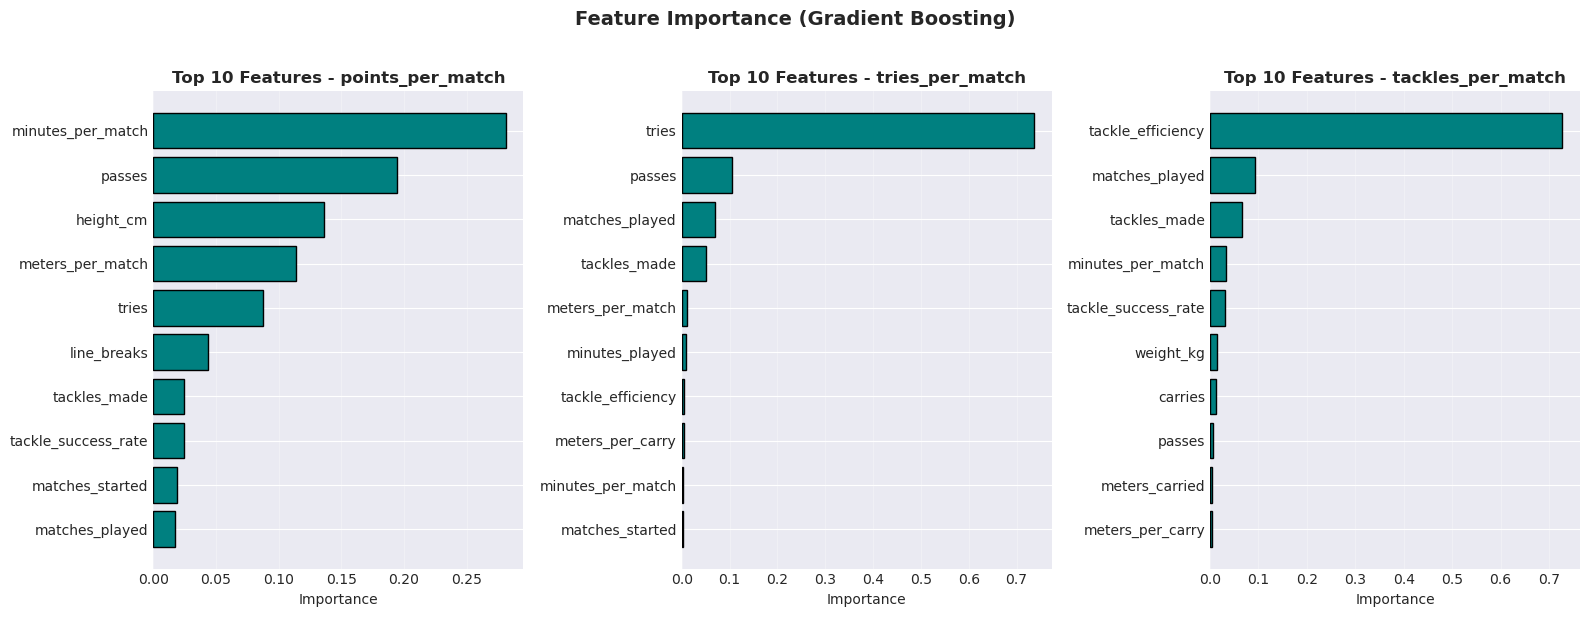

In [12]:
# Feature Importance - Random Forest and Gradient Boosting
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, target in enumerate(targets):
    # Train Gradient Boosting
    gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train[target])
    
    # Get feature importance
    importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': gb.feature_importances_
    }).sort_values('Importance', ascending=True).tail(10)  # Top 10
    
    # Plot
    axes[i].barh(importance['Feature'], importance['Importance'], color='teal', edgecolor='black')
    axes[i].set_xlabel('Importance')
    axes[i].set_title(f'Top 10 Features - {target}', fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

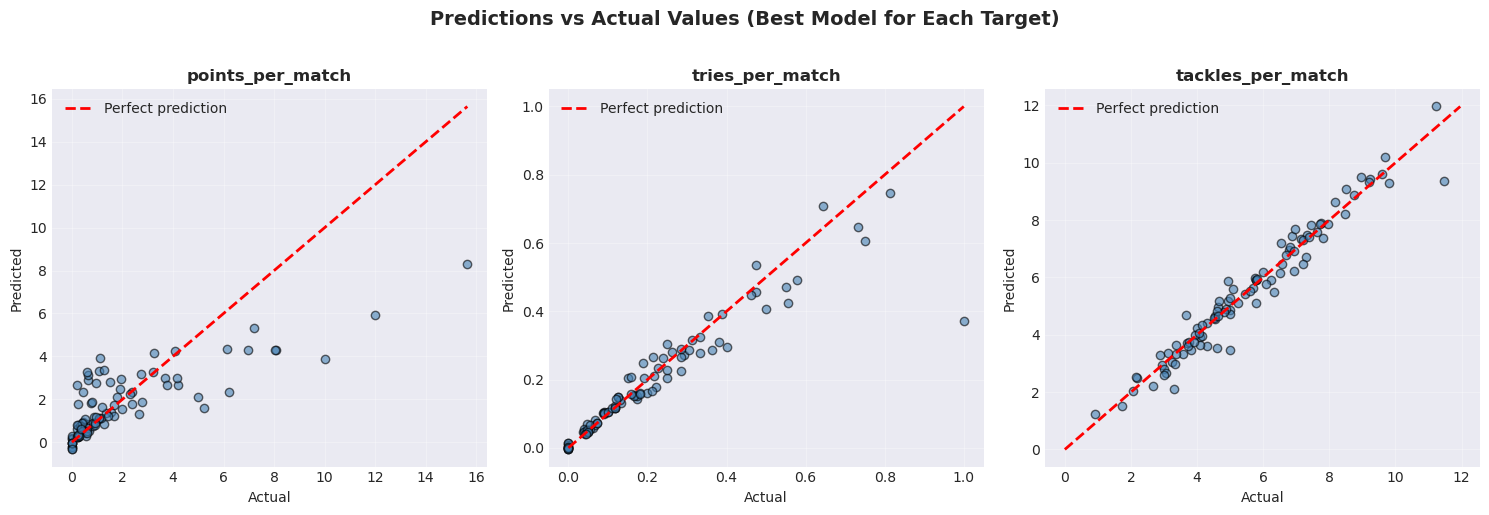

In [11]:
# Predictions vs Actual - Best model for each target
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

best_models = {
    'points_per_match': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'tries_per_match': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'tackles_per_match': LinearRegression()
}

for i, target in enumerate(targets):
    model = best_models[target]
    
    # Use appropriate data
    if target == 'tackles_per_match':
        model.fit(X_train_scaled, y_train[target])
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train[target])
        y_pred = model.predict(X_test)
    
    # Plot
    axes[i].scatter(y_test[target], y_pred, alpha=0.6, color='steelblue', edgecolor='black')
    
    # Perfect prediction line
    max_val = max(y_test[target].max(), y_pred.max())
    axes[i].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{target}', fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Predictions vs Actual Values (Best Model for Each Target)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

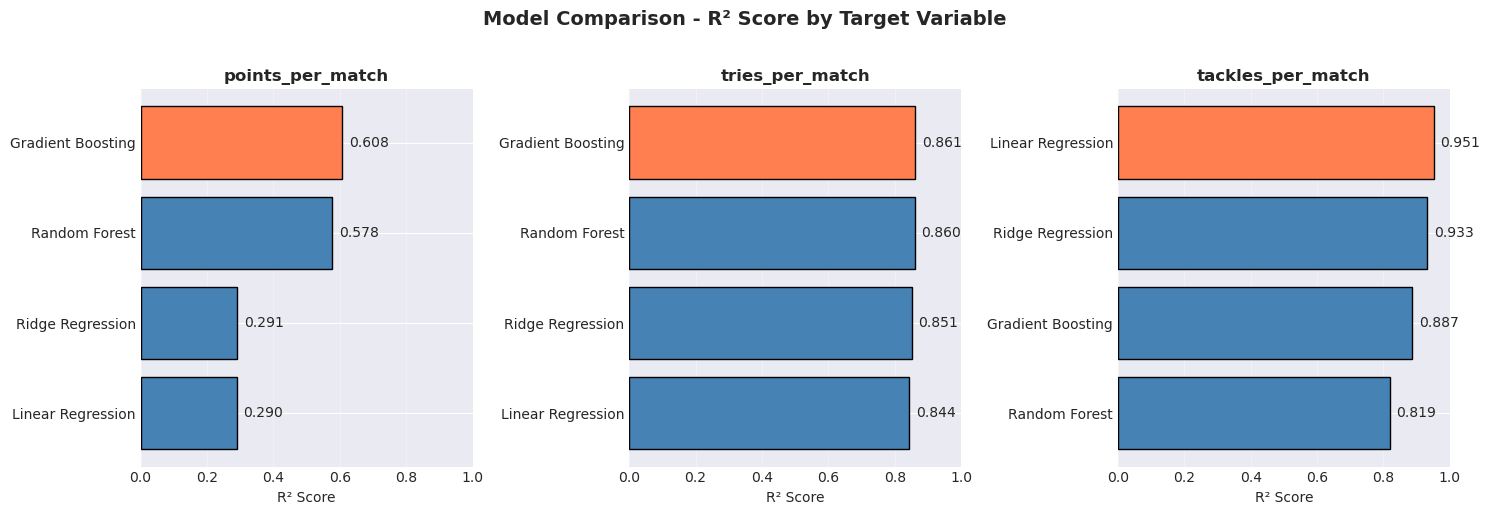

In [10]:
# Visualize results - R² comparison for all models and targets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, target in enumerate(targets):
    target_results = results_df[results_df['Target'] == target].sort_values('R2', ascending=True)
    
    colors = ['steelblue' if r < target_results['R2'].max() else 'coral' 
              for r in target_results['R2']]
    
    axes[i].barh(target_results['Model'], target_results['R2'], color=colors, edgecolor='black')
    axes[i].set_xlabel('R² Score')
    axes[i].set_title(f'{target}', fontweight='bold', fontsize=12)
    axes[i].set_xlim(0, 1)
    axes[i].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for j, (model, r2) in enumerate(zip(target_results['Model'], target_results['R2'])):
        axes[i].text(r2 + 0.02, j, f'{r2:.3f}', va='center', fontsize=10)

plt.suptitle('Model Comparison - R² Score by Target Variable', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Display tackles_per_match results specifically
print("TACKLES_PER_MATCH - Full Results")
print("-" * 50)

tackles_results = results_df[results_df['Target'] == 'tackles_per_match'][['Model', 'MAE', 'RMSE', 'R2']]
tackles_results = tackles_results.sort_values('R2', ascending=False)
print(tackles_results.to_string(index=False))

print(f"\nBest model: {tackles_results.iloc[0]['Model']} (R² = {tackles_results.iloc[0]['R2']:.3f})")

TACKLES_PER_MATCH - Full Results
--------------------------------------------------
            Model      MAE     RMSE       R2
Linear Regression 0.330109 0.474473 0.951467
 Ridge Regression 0.412208 0.559353 0.932550
Gradient Boosting 0.526231 0.722867 0.887351
    Random Forest 0.707663 0.916260 0.819013

Best model: Linear Regression (R² = 0.951)


In [8]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results by target
print("RESULTS SUMMARY\n")

for target in targets:
    print(f"\n {target.upper()}")
    print("-" * 50)
    target_results = results_df[results_df['Target'] == target][['Model', 'MAE', 'RMSE', 'R2']]
    target_results = target_results.sort_values('R2', ascending=False)
    print(target_results.to_string(index=False))
    
    # Best model
    best = target_results.iloc[0]
    print(f"\n Best model: {best['Model']} (R² = {best['R2']:.3f})")

RESULTS SUMMARY


 POINTS_PER_MATCH
--------------------------------------------------
            Model      MAE     RMSE       R2
Gradient Boosting 0.944579 1.690086 0.607561
    Random Forest 0.860577 1.753441 0.577588
 Ridge Regression 1.507378 2.271865 0.290881
Linear Regression 1.537277 2.273691 0.289741

 Best model: Gradient Boosting (R² = 0.608)

 TRIES_PER_MATCH
--------------------------------------------------
            Model      MAE     RMSE       R2
Gradient Boosting 0.030310 0.074424 0.860908
    Random Forest 0.033602 0.074537 0.860485
 Ridge Regression 0.036049 0.076972 0.851223
Linear Regression 0.037591 0.078869 0.843798

 Best model: Gradient Boosting (R² = 0.861)

 TACKLES_PER_MATCH
--------------------------------------------------
            Model      MAE     RMSE       R2
Linear Regression 0.330109 0.474473 0.951467
 Ridge Regression 0.412208 0.559353 0.932550
Gradient Boosting 0.526231 0.722867 0.887351
    Random Forest 0.707663 0.916260 0.819013

 Best m

In [7]:
# Train all models and store results
results = []

for target in targets:
    print(f"\n{'='*60}")
    print(f"TARGET: {target}")
    print('='*60)
    
    for model_name, model in models.items():
        # Use scaled data for Linear/Ridge, original for tree-based
        if model_name in ['Linear Regression', 'Ridge Regression']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test
        
        # Train the model
        model.fit(X_tr, y_train[target])
        
        # Predict
        y_pred = model.predict(X_te)
        
        # Evaluate
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
        r2 = r2_score(y_test[target], y_pred)
        
        # Store results
        results.append({
            'Target': target,
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })
        
        print(f"\n   {model_name}:")
        print(f"      MAE:  {mae:.3f}")
        print(f"      RMSE: {rmse:.3f}")
        print(f"      R²:   {r2:.3f}")

print(f"\n{'='*60}")
print("All 12 models trained successfully!")
print('='*60)


TARGET: points_per_match

   Linear Regression:
      MAE:  1.537
      RMSE: 2.274
      R²:   0.290

   Ridge Regression:
      MAE:  1.507
      RMSE: 2.272
      R²:   0.291

   Random Forest:
      MAE:  0.861
      RMSE: 1.753
      R²:   0.578

   Gradient Boosting:
      MAE:  0.945
      RMSE: 1.690
      R²:   0.608

TARGET: tries_per_match

   Linear Regression:
      MAE:  0.038
      RMSE: 0.079
      R²:   0.844

   Ridge Regression:
      MAE:  0.036
      RMSE: 0.077
      R²:   0.851

   Random Forest:
      MAE:  0.034
      RMSE: 0.075
      R²:   0.860

   Gradient Boosting:
      MAE:  0.030
      RMSE: 0.074
      R²:   0.861

TARGET: tackles_per_match

   Linear Regression:
      MAE:  0.330
      RMSE: 0.474
      R²:   0.951

   Ridge Regression:
      MAE:  0.412
      RMSE: 0.559
      R²:   0.933

   Random Forest:
      MAE:  0.708
      RMSE: 0.916
      R²:   0.819

   Gradient Boosting:
      MAE:  0.526
      RMSE: 0.723
      R²:   0.887

All 12 model

In [6]:
# Normalize features (important for Linear and Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the 4 models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("Models defined:")
for name in models.keys():
    print(f"   - {name}")

print(f"\nTraining data: {X_train_scaled.shape}")
print(f"Targets: {targets}")
print(f"\nReady to train {len(models)} models × {len(targets)} targets = {len(models) * len(targets)} total models!")

Models defined:
   - Linear Regression
   - Ridge Regression
   - Random Forest
   - Gradient Boosting

Training data: (97, 20)
Targets: ['points_per_match', 'tries_per_match', 'tackles_per_match']

Ready to train 4 models × 3 targets = 12 total models!


In [5]:
# Extract target variables (y)
# We predict 2024-2025 performance based on 2023-2024 data

targets = ['points_per_match', 'tries_per_match', 'tackles_per_match']

y_train = {}
y_test = {}

for target in targets:
    y_train[target] = train_aligned[target].values
    y_test[target] = test_aligned[target].values

print("Target variables extracted:")
for target in targets:
    print(f"\n   {target}:")
    print(f"      y_train: {y_train[target].shape[0]} values | mean: {y_train[target].mean():.2f}")
    print(f"      y_test:  {y_test[target].shape[0]} values | mean: {y_test[target].mean():.2f}")

Target variables extracted:

   points_per_match:
      y_train: 97 values | mean: 1.53
      y_test:  97 values | mean: 1.85

   tries_per_match:
      y_train: 97 values | mean: 0.17
      y_test:  97 values | mean: 0.20

   tackles_per_match:
      y_train: 97 values | mean: 5.34
      y_test:  97 values | mean: 5.53


In [4]:
# Get players that appear in BOTH seasons
train_players = set(train_data['player_name'].unique())
test_players = set(test_data['player_name'].unique())
common_players = list(train_players.intersection(test_players))

print(f"Players in both seasons: {len(common_players)}")

# Create aligned datasets
# X = features from 2023-2024
# y = targets from 2024-2025 (what we want to predict)

train_aligned = train_data[train_data['player_name'].isin(common_players)].sort_values('player_name')
test_aligned = test_data[test_data['player_name'].isin(common_players)].sort_values('player_name')

# Verify alignment
print(f"\nTrain aligned: {train_aligned.shape[0]} players")
print(f"Test aligned: {test_aligned.shape[0]} players")

# Extract X (features) and y (targets)
X_train = train_aligned[feature_columns].values
X_test = test_aligned[feature_columns].values

print(f"\n X_train shape: {X_train.shape}")
print(f" X_test shape: {X_test.shape}")

Players in both seasons: 97

Train aligned: 97 players
Test aligned: 97 players

 X_train shape: (97, 20)
 X_test shape: (97, 20)


In [3]:
# Updated features list (including our engineered features)
feature_columns = [
    # Physical profile
    'age', 'height_cm', 'weight_kg',
    
    # Playing time
    'matches_played', 'matches_started', 'minutes_played',
    'minutes_per_match',  # Engineered
    
    # Offensive performance
    'tries', 'carries', 'meters_carried', 'line_breaks', 
    'offloads', 'passes',
    'meters_per_match',   # Engineered
    'meters_per_carry',   # Engineered
    
    # Defensive performance
    'tackles_made', 'tackle_success_rate', 'turnovers_won',
    'tackle_efficiency',  # Engineered
    
    # Discipline
    'penalties_conceded'
]

print(f"Features selected: {len(feature_columns)}")
print(f"\nOriginal features: 16")
print(f"Engineered features: 4")
print(f"   - minutes_per_match")
print(f"   - meters_per_match")
print(f"   - meters_per_carry")
print(f"   - tackle_efficiency")

# Check all features exist
missing = [f for f in feature_columns if f not in train_data.columns]
if missing:
    print(f"\nMissing: {missing}")
else:
    print(f"\nAll {len(feature_columns)} features available!")

Features selected: 20

Original features: 16
Engineered features: 4
   - minutes_per_match
   - meters_per_match
   - meters_per_carry
   - tackle_efficiency

All 20 features available!


In [2]:
# Load the cleaned dataset with engineered features
df = pd.read_csv('../data/top14_players_clean_with_features.csv', sep=';')

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# Split by season
train_data = df[df['season'] == '2023-2024'].copy()
test_data = df[df['season'] == '2024-2025'].copy()

print(f"\nTraining set (2023-2024): {train_data.shape[0]} players")
print(f"Test set (2024-2025): {test_data.shape[0]} players")

# Define the 3 target variables
targets = ['points_per_match', 'tries_per_match', 'tackles_per_match']
print(f"\nTarget variables: {targets}")

Dataset loaded: 196 rows × 42 columns

Training set (2023-2024): 97 players
Test set (2024-2025): 99 players

Target variables: ['points_per_match', 'tries_per_match', 'tackles_per_match']


In [1]:
# ============================================
# 02 - Machine Learning Models
# Rugby Portfolio Analytics
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully
